In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math 
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
import random

In [2]:
df= pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/regression/housing.csv')


In [3]:
class Regressor:
    def __init__(self, X, y, tol , learning_rate, iterations, reg_param,SGDiterations,batch_size , gd= False, regp = False, sgd = False):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.tol = tol 
        #self.m , self.n = self.X.shape
        self.gd = gd
        self.iterations_count = []
        self.error_seq = []
        self.reg_param = reg_param
        self.regp = regp
        self.sgd = sgd
        self.SGDiterations = SGDiterations
        self.batch_size = batch_size
        
    def trainTestSplit(self):
        x_train , x_test, y_train, y_test = train_test_split(self.X,self.y, test_size = 0.3, random_state = 0)
        return x_train , x_test, y_train, y_test
    
    def addBias(self,X):
        return np.column_stack([np.ones((X.shape[0],1)),X])
    
    def normData(self,X):
        mean = np.mean(X, 0)
        std =  np.std(X , 0)
        nor =  ( X - mean) / std
        x_norm = self.addBias(nor)
        return x_norm, mean, std # retrun std and mean so that you need to normalise test data on this mean and std 
    
    def normTestData(self, X, TrainMean, TrainStd):
        x_norm = ( X - TrainMean ) / TrainStd
        x_norm = self.addBias(x_norm)
        return x_norm
    
    # closed form or normal equation 
    # find rank of the matrix to see full rank to evaluate invertibility 
    
    def rank(self, X, esp = 1e-21):
        u ,s ,vh = np.linalg.svd(X)
        # s is diagonol matrix - if all values of s are not 0 and >0 we are good 
        
        return len([x for x in s if abs(s) > esp])
    # anathor way to check the rnak of matix
    def checkMatrix(self,X):
        
        x_rank  = np.linalg.matrix_rank(X)
        if x_rank == min(X.shape[0], X.shape[1]):
            self.fullRank = True
            print('Data is full rank')
        else:
            self.fullRank = False
            print('Data not full rank')
            
    def checkInvertibility(self,X):
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
            print('Data is low rank')
        else:
            self.lowRank = False
            print('Data is not low rank')
    
    def normalEq(self,X,y):
        w = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
        return w
    
    def regNormalEquation(self,X,y):
        w = np.linalg.inv( np.dot(X.T,X) + self.reg_param * ( np.identity(X.shape[1]) )  ).dot(X.T).dot(y)
        return w
    
    
    def gradientDescent(self,X,y):
        #error_seq = []
        prev_error = float('inf')
        
        for t in tqdm(range(self.iterations)):
            self.w = self.w - self.learning_rate * self.costDerivative(X,y)
            cur = self.rmse(X,y)
            diff = prev_error - cur
            prev_error = cur
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if abs(diff) < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break          
                
    def regGradientDescent(self, X,y):
        
        prev_error = float('inf')
        
        for t in tqdm(range(self.iterations)):
            w_update = self.w * (1 - self.learning_rate *( self.reg_param / X.shape[0]))
            self.w  = w_update - (self.learning_rate  * self.regCostDerivative(X,y))  
            cur = self.rmse(X,y)
            diff = prev_error - cur
            prev_error = cur
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if abs(diff) < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break
                
    def sgradientDescent(self, X, y ,batch_size):
        prev_error = float('inf')
        
        for t in tqdm(range(self.SGDiterations)):
            seq = []
            idx = np.random.randint(0, X.shape[0], batch_size)
            #x_sgd = X[idx]
            #y_sgd = y[idx]
            #print(x_sgd)
            #for i in range(batch_size):
            self.w = self.w - self.learning_rate * self.costDerivative(X[idx],y[idx])
            cur = self.rmse(X[idx],y[idx])
            diff = prev_error - cur
            prev_error = cur
            #seq.append(cur)
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if abs(diff) < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break
        
    def regSGradientDescent(self,X,y, batch_size):
        prev_error = float('inf')
        
        for t in tqdm(range(self.SGDiterations)):
            seq = []
            idx = np.random.randint(0, X.shape[0], batch_size)
            #x_sgd = X[idx]
            #y_sgd = y[idx]
            #for i in range(batch_size):
            w_update = self.w * (1 - self.learning_rate * (self.reg_param / batch_size ))
            self.w  = w_update - (self.learning_rate  * self.regCostDerivative(X[idx],y[idx]))
                #self.W = slef.w - self.learning_rate * self.costDerivative(X[i,:],y[i,1])
            cur = self.rmse(X[idx],y[idx])
            diff = prev_error - cur
            prev_error = cur
            #seq.append(cur)
            #self.error_seq.append(np.mean(seq))
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if abs(diff) < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break
        
            
    def sse(self,X,y):
        y_hat = self.predict(X)
        return ((y_hat - y)**2).sum()
    
    def rmse(self,X,y):
        dum = self.sse(X,y)
        return np.sqrt(dum / X.shape[0])
    
    def predict(self,X):
        return X.dot(self.w)
    
    def costFunc(self,X, y):
        return self.sse(X,y)/2
    
    def regCostFunc(self,X,y):
        return ( self.sse(X,y) + (self.reg_param * np.dot(X.T,X).sum()) ) / 2
    
    def costDerivative(self,X,y):
        y_hat = self.predict(X)
        return np.dot(y_hat - y , X)
    
    def regCostDerivative(self,X,y):
        y_hat = self.predict(X)
        return np.dot(y_hat - y , X) / X.shape[0]
    
    
    def fit(self):
        self.x_train , self.x_test, self.y_train, self.y_test = self.trainTestSplit()
        self.x_train, self.mean, self.std = self.normData(self.x_train)
        self.x_test = self.normTestData(self.x_test, self.mean, self.std)
        
        self.checkMatrix(self.x_train)
        self.checkInvertibility(self.x_train)
        
        if self.fullRank and not self.lowRank and not self.gd and not self.sgd:
            print("solving using normal equation...")
            if not self.regp:
                print("without regularisation")
                self.w = self.normalEq(self.x_train, self.y_train)
                
            else: 
                print("with regularisation")
                self.w = self.regNormalEquation(self.x_train, self.y_train)
            
        elif not self.sgd: 
            print("solving using gradient descent...")
            self.w = np.ones(self.x_train.shape[1], dtype = np.float64) *0
            
            if not self.regp:
                print("without regularisation ")
                self.gradientDescent(self.x_train,self.y_train)
                
            else: 
                print("with regularisation")
                self.regGradientDescent(self.x_train,self.y_train)
                
        else: 
            print("solving using stochastic gradient descent...")
            self.w = np.ones(self.x_train.shape[1], dtype = np.float64) *0
            
            if not self.regp:
                print("without regularisation ")
                
                self.sgradientDescent(self.x_train,self.y_train, self.batch_size)
                
            else: 
                print("with regularisation")
                self.regSGradientDescent(self.x_train,self.y_train, self.batch_size)
                
                
            
        print(self.w)
        
    def plotError(self, figsize=(7,5)):
        if not self.sgd and not self.gd:
            return
        plt.figure(figsize=figsize)
        plt.plot(self.iterations_count,self.error_seq)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title("Iterations vs Cost")
        plt.show()
        
    def score(self,X,y):
        return 1-(np.sum(((y-self.predict(X))**2))/np.sum((y-np.mean(y))**2))
        
        

Data is full rank
Data is not low rank
solving using gradient descent...
without regularisation 


  0%|                                                                            | 30/50000 [00:00<00:01, 30002.17it/s]

model stopped - no further updating
[22.72928728 -0.71502389  0.61050987 -0.1830346   0.76362304 -0.9822018
  3.11998658  0.04996472 -1.84225699  0.70895661 -0.3872768  -2.1058927
  0.66462073 -3.52549145]


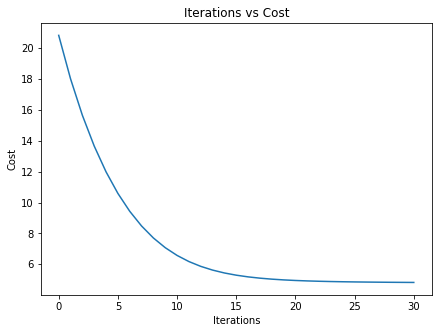

In [4]:
reg = Regressor(df.values[:,0:-1], df.values[:,-1], learning_rate= 0.0004, tol = 0.005, iterations = 50000, 
                SGDiterations = 100,reg_param = 0.001, batch_size= 1
               , gd = True, regp = False, sgd = False )
reg.fit()
reg.plotError()

In [5]:
reg.score(reg.x_test,reg.y_test)

0.7162068841225199

Data is full rank
Data is not low rank
solving using gradient descent...
with regularisation


  3%|██                                                                        | 1435/50000 [00:00<00:00, 60791.31it/s]

model stopped - no further updating
[10.02258868 -0.56008273  0.50779258 -0.55561038  0.66856837 -0.42222765
  2.00429242 -0.31290892 -0.25080621 -0.24735009 -0.52153366 -1.35277963
  0.50963032 -1.82541237]


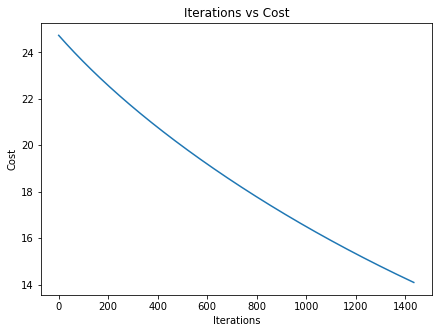

In [81]:
reg_wreg = Regressor(df.values[:,0:-1], df.values[:,-1], learning_rate= 0.0004, tol = 0.005, iterations = 50000, 
                SGDiterations = 100,reg_param = 0.01, batch_size= 20
               , gd = True, regp = True, sgd = False )
reg_wreg.fit()
reg_wreg.plotError()

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
without regularisation 


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 31429.78it/s]

[22.5509483  -0.67382154  0.70860874 -0.24493256  0.82795183 -1.06516732
  3.16601591  0.06552144 -1.7686399   0.44060855 -0.36314008 -2.133752
  0.70313572 -3.2588054 ]


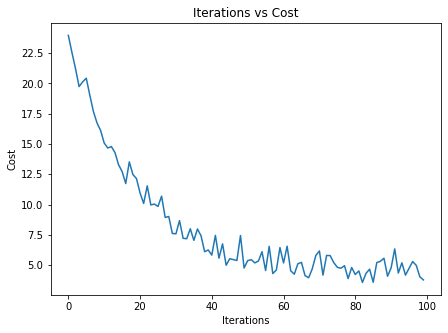

In [44]:
reg_sgd = Regressor(df.values[:,0:-1], df.values[:,-1], learning_rate= 0.0004, tol = 0.005, iterations = 50000, 
                SGDiterations = 100,reg_param = 0.001, batch_size= 100
               , gd = False, regp = False, sgd = True )
reg_sgd.fit()
reg_sgd.plotError()

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
with regularisation


 28%|████████████████████▊                                                      | 1387/5000 [00:00<00:00, 29069.62it/s]

model stopped - no further updating
[ 9.78693388 -0.55748605  0.55059397 -0.56283663  0.6950006  -0.44212198
  1.98235419 -0.33413643 -0.22994157 -0.22298456 -0.49512627 -1.30873009
  0.51792916 -1.82596771]


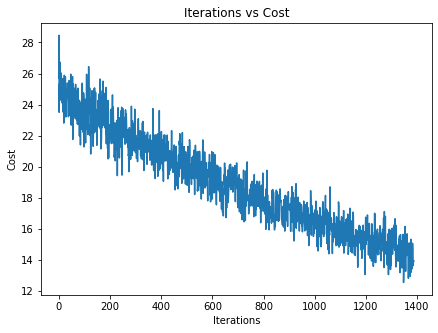

In [84]:
reg_sgd_wreg = Regressor(df.values[:,0:-1], df.values[:,-1], learning_rate= 0.0004, tol = 0.0005, iterations = 50000, 
                SGDiterations = 5000,reg_param = 0.01, batch_size= 100
               , gd = False, regp = True, sgd = True )
reg_sgd_wreg.fit()
reg_sgd_wreg.plotError()

In [86]:
reg_Ne = Regressor(df.values[:,0:-1], df.values[:,-1], learning_rate= 0.0004, tol = 0.005, iterations = 50000, 
                SGDiterations = 100,reg_param = 0.001, batch_size= 1
               , gd = False, regp = False, sgd = False )
reg_Ne.fit()
reg_Ne.plotError()


Data is full rank
Data is not low rank
solving using normal equation...
without regularisation
[22.93399433 -0.90751811  1.04796575  0.38867104  0.6622465  -2.17214484
  2.58716716  0.50645061 -2.59559964  2.30818886 -1.67320027 -2.33651383
  0.65618617 -3.99472177]


In [87]:
reg_Ne_wreg = Regressor(df.values[:,0:-1], df.values[:,-1], learning_rate= 0.0004, tol = 0.005, iterations = 50000, 
                SGDiterations = 100,reg_param = 0.001, batch_size= 1
               , gd = False, regp = True, sgd = False )
reg_Ne_wreg.fit()
reg_Ne_wreg.plotError()

Data is full rank
Data is not low rank
solving using normal equation...
with regularisation
[22.93392937 -0.9075087   1.04794718  0.38863798  0.66225127 -2.1721009
  2.58718049  0.50642973 -2.59557244  2.308099   -1.67312074 -2.33650137
  0.65618524 -3.99469858]


In [88]:
print('                        --------------RMSE values--------------')
print('\n                       Gradient Descent   Stochastic GD       Normal Eq')
print('                        ---------------  -------------        ---------')
print('With regularisation :   {:.04}              {:.04}               {:.04}'.format(reg_wreg.rmse(reg_wreg.x_test,reg_wreg.y_test),\
                                                                                  reg_sgd_wreg.rmse(reg_sgd_wreg.x_test,reg_sgd_wreg.y_test),\
                                                                                    reg_Ne_wreg.rmse(reg_Ne_wreg.x_test,reg_Ne_wreg.y_test)))

print('Without regularisation: {:.04}             {:.04}               {:.04}'.format(reg.rmse(reg.x_test,reg.y_test),\
                                                                                reg_sgd.rmse(reg_sgd.x_test,reg_sgd.y_test),\
                                                                                reg_Ne.rmse(reg_Ne.x_test,reg_Ne.y_test)))


                        --------------RMSE values--------------

                       Gradient Descent   Stochastic GD       Normal Eq
                        ---------------  -------------        ---------
With regularisation :   13.3              13.52               4.624
Without regularisation: 4.726             4.768               4.624


As SGD has a batch size to be determined which shuffles the data randomly to select the data points, more number of iterations with smaller batch size might work to converge faster and show lower rmse value.  

In [89]:
print('                        --------------SSE values--------------')
print('\n                       Gradient Descent   Stochastic GD       Normal Eq')
print('                        ---------------  -------------        ---------')
print('With regularisation :   {:.04}              {:.04}               {:.04}'.format(reg_wreg.sse(reg_wreg.x_test,reg_wreg.y_test),\
                                                                                  reg_sgd_wreg.sse(reg_sgd_wreg.x_test,reg_sgd_wreg.y_test),\
                                                                                    reg_Ne_wreg.sse(reg_Ne_wreg.x_test,reg_Ne_wreg.y_test)))

print('Without regularisation: {:.04}             {:.04}               {:.04}'.format(reg.sse(reg.x_test,reg.y_test),\
                                                                                reg_sgd.sse(reg_sgd.x_test,reg_sgd.y_test),\
                                                                                reg_Ne.sse(reg_Ne.x_test,reg_Ne.y_test)))


                        --------------SSE values--------------

                       Gradient Descent   Stochastic GD       Normal Eq
                        ---------------  -------------        ---------
With regularisation :   2.689e+04              2.777e+04               3.25e+03
Without regularisation: 3.395e+03             3.455e+03               3.25e+03


# concrete dataset

In [90]:
df1 = pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/regression/concreteData.csv')

Data is full rank
Data is not low rank
solving using gradient descent...
without regularisation 


  0%|▏                                                                          | 140/50000 [00:00<00:01, 31277.43it/s]

model stopped - no further updating
[35.55869444 12.44770816  8.66659059  5.53272991 -2.91503991  2.06868838
  1.26049025  1.15047029  7.34790782]


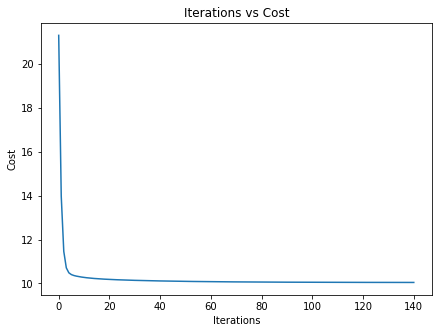

In [92]:
reg1 = Regressor(df1.values[:,0:-1], df1.values[:,-1], learning_rate= 0.0007, tol = 0.0001, iterations = 50000,
                 SGDiterations = 100, reg_param = 0.003, batch_size= 1
               , gd = True, regp = False, sgd = False)
reg1.fit()
reg1.plotError()

Data is full rank
Data is not low rank
solving using gradient descent...
with regularisation


 10%|███████▋                                                                  | 5225/50000 [00:00<00:01, 40353.54it/s]

model stopped - no further updating
[34.64307446  7.16089812  3.2209293   0.31971631 -4.82334571  3.74997908
 -1.4568622  -2.99928958  6.72372494]


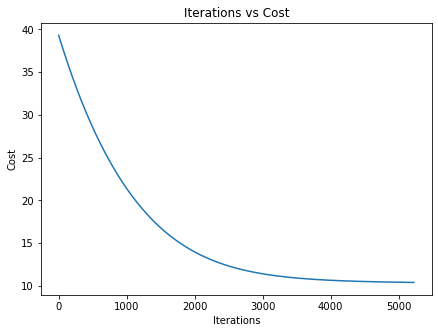

In [93]:
reg1_wreg = Regressor(df1.values[:,0:-1], df1.values[:,-1], learning_rate= 0.0007, tol = 0.0001, iterations = 50000,
                 SGDiterations = 100, reg_param = 0.003, batch_size= 1
               , gd = True, regp = True, sgd = False)
reg1_wreg.fit()
reg1_wreg.plotError()

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
without regularisation 


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 14019.33it/s]

[35.09243976  7.88733228  4.04535157  1.46127224 -4.75132151  2.93396897
 -1.23759785 -2.69766797  6.90848678]


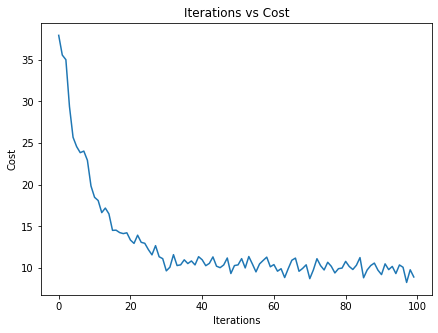

In [94]:
reg1_sgd = Regressor(df1.values[:,0:-1], df1.values[:,-1], learning_rate= 0.0007, tol = 0.0001, iterations = 50000,
                 SGDiterations = 100, reg_param = 0.003, batch_size= 100
               , gd = False, regp = False, sgd = True)
reg1_sgd.fit()
reg1_sgd.plotError()

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
with regularisation


 39%|█████████████████████████████▏                                             | 1943/5000 [00:00<00:00, 33624.62it/s]

model stopped - no further updating
[26.4243211   5.64868277  1.92133977 -0.69325987 -3.45743485  3.70533963
 -1.34998375 -2.42738423  4.86075852]


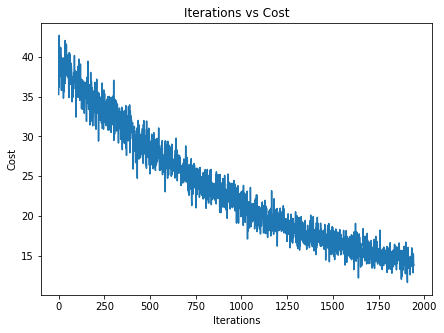

In [97]:
reg1_sgd_wreg = Regressor(df1.values[:,0:-1], df1.values[:,-1], learning_rate= 0.0007, tol = 0.0001, iterations = 50000,
                 SGDiterations = 5000, reg_param = 0.003, batch_size= 100
               , gd = False, regp = True, sgd = True)
reg1_sgd_wreg.fit()
reg1_sgd_wreg.plotError()

In [98]:
reg1_Ne = Regressor(df1.values[:,0:-1], df1.values[:,-1], learning_rate= 0.0007, tol = 0.0001, iterations = 50000,
                 SGDiterations = 100, reg_param = 0.003, batch_size= 1
               , gd = False, regp = False, sgd = False)
reg1_Ne.fit()
reg1_Ne.plotError()

Data is full rank
Data is not low rank
solving using normal equation...
without regularisation
[35.55869444 13.07061719  9.29612788  6.07754028 -2.38797659  2.13444427
  1.74782814  1.75752107  7.36636378]


In [99]:
reg1_Ne_wreg = Regressor(df1.values[:,0:-1], df1.values[:,-1], learning_rate= 0.0007, tol = 0.0001, iterations = 50000,
                 SGDiterations = 100, reg_param = 0.003, batch_size= 1
               , gd = False, regp = True, sgd = False)
reg1_Ne_wreg.fit()
reg1_Ne_wreg.plotError()

Data is full rank
Data is not low rank
solving using normal equation...
with regularisation
[35.55854628 13.06979401  9.29530217  6.07681127 -2.38853583  2.13444129
  1.74726217  1.75679001  7.36629947]


In [100]:
print('                        --------------RMSE values--------------')
print('\n                       Gradient Descent   Stochastic GD       Normal Eq')
print('                        ---------------  -------------        ---------')
print('With regularisation :   {:.04}              {:.04}               {:.04}'.format(reg1_wreg.rmse(reg1_wreg.x_test,reg1_wreg.y_test),\
                                                                                  reg1_sgd_wreg.rmse(reg1_sgd_wreg.x_test,reg1_sgd_wreg.y_test),\
                                                                                    reg1_Ne_wreg.rmse(reg1_Ne_wreg.x_test,reg1_Ne_wreg.y_test)))

print('Without regularisation: {:.04}             {:.04}               {:.04}'.format(reg1.rmse(reg1.x_test,reg1.y_test),\
                                                                                reg1_sgd.rmse(reg1_sgd.x_test,reg1_sgd.y_test),\
                                                                                reg1_Ne.rmse(reg1_Ne.x_test,reg1_Ne.y_test)))


                        --------------RMSE values--------------

                       Gradient Descent   Stochastic GD       Normal Eq
                        ---------------  -------------        ---------
With regularisation :   11.35              14.77               11.11
Without regularisation: 11.1             11.31               11.11


In [101]:
print('                        --------------SSE values--------------')
print('\n                       Gradient Descent   Stochastic GD       Normal Eq')
print('                        ---------------  -------------        ---------')
print('With regularisation :   {:.04}              {:.04}               {:.04}'.format(reg1_wreg.sse(reg1_wreg.x_test,reg1_wreg.y_test),\
                                                                                  reg1_sgd_wreg.sse(reg1_sgd_wreg.x_test,reg1_sgd_wreg.y_test),\
                                                                                    reg1_Ne_wreg.sse(reg1_Ne_wreg.x_test,reg1_Ne_wreg.y_test)))

print('Without regularisation: {:.04}             {:.04}               {:.04}'.format(reg1.sse(reg1.x_test,reg1.y_test),\
                                                                                reg1_sgd.sse(reg1_sgd.x_test,reg1_sgd.y_test),\
                                                                                reg1_Ne.sse(reg1_Ne.x_test,reg1_Ne.y_test)))


                        --------------SSE values--------------

                       Gradient Descent   Stochastic GD       Normal Eq
                        ---------------  -------------        ---------
With regularisation :   3.984e+04              6.74e+04               3.812e+04
Without regularisation: 3.808e+04             3.953e+04               3.812e+04


# Yacht dataset

In [102]:
df2 = pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/regression/yachtData.csv')

Data is full rank
Data is not low rank
solving using gradient descent...
without regularisation 


  0%|                                                                            | 19/50000 [00:00<00:02, 17126.97it/s]

model stopped - no further updating
[10.65570116  0.54860892 -0.64086545 -0.1248648  -0.05651829 -0.2141502
 12.78556211]


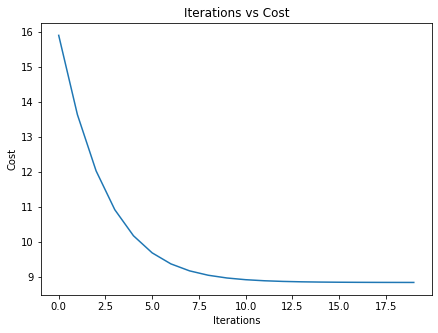

In [103]:
reg2 = Regressor(df2.values[:,0:-1], df2.values[:,-1], learning_rate= 0.001, tol = 0.001, iterations = 50000,
                 SGDiterations = 40, reg_param = 0.03, batch_size = 100
               , gd = True, regp = False, sgd = False)
reg2.fit()
reg2.plotError()

Data is full rank
Data is not low rank
solving using gradient descent...
with regularisation


 11%|███████▊                                                                  | 5306/50000 [00:00<00:00, 53251.76it/s]

model stopped - no further updating
[10.67503133  0.54362743 -0.6420795  -0.11982502 -0.05949954 -0.21873241
 12.80898829]


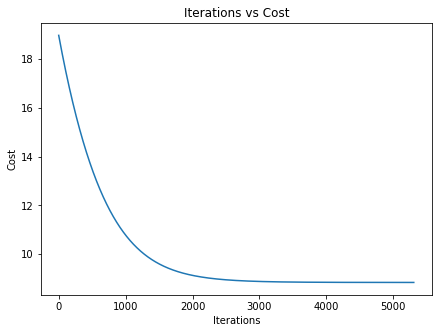

In [104]:
reg2_wreg = Regressor(df2.values[:,0:-1], df2.values[:,-1], learning_rate= 0.001, tol = 0.000001, iterations = 50000,
                 SGDiterations = 40, reg_param = 0.3, batch_size = 100
               , gd = True, regp = True, sgd = False)
reg2_wreg.fit()
reg2_wreg.plotError()

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
without regularisation 


 15%|███████████▋                                                                | 773/5000 [00:00<00:00, 29729.93it/s]

model stopped - no further updating
[10.77378338  0.33372501 -0.56214547  0.10494035 -0.43822224 -0.71036045
 12.97690969]


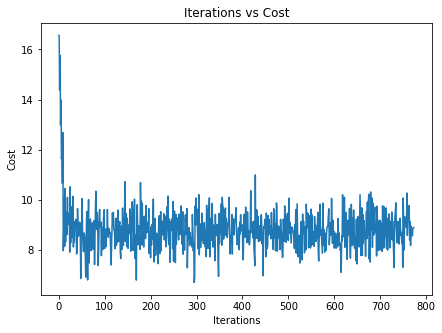

In [106]:
reg2_sgd = Regressor(df2.values[:,0:-1], df2.values[:,-1], learning_rate= 0.001, tol = 0.001, iterations = 50000,
                 SGDiterations = 5000, reg_param = 0.03, batch_size = 100
               , gd = False, regp = False, sgd = True)
reg2_sgd.fit()
reg2_sgd.plotError()

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
with regularisation


 35%|██████████████████████████                                                 | 1736/5000 [00:00<00:00, 28996.62it/s]

model stopped - no further updating
[ 8.85335595  0.55307633 -0.5052075  -0.14457977 -0.03915989 -0.2074784
 10.592909  ]


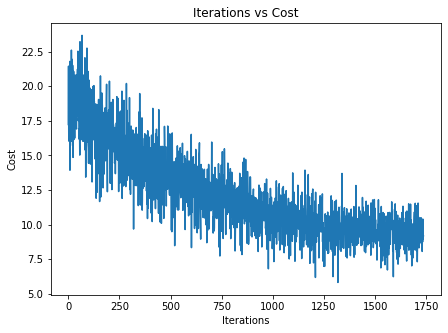

In [107]:
reg2_sgd_wreg = Regressor(df2.values[:,0:-1], df2.values[:,-1], learning_rate= 0.001, tol = 0.001, iterations = 50000,
                 SGDiterations = 5000, reg_param = 0.03, batch_size = 100
               , gd = False, regp = True, sgd = True)
reg2_sgd_wreg.fit()
reg2_sgd_wreg.plotError()

In [109]:
reg2_Ne = Regressor(df2.values[:,0:-1], df2.values[:,-1], learning_rate= 0.001, tol = 0.001, iterations = 50000,
                 SGDiterations = 40, reg_param = 0.03, batch_size = 100
               , gd = False, regp = False, sgd = False)
reg2_Ne.fit()
reg2_Ne.plotError()

Data is full rank
Data is not low rank
solving using normal equation...
without regularisation
[10.74271028  0.54271589 -0.48644592  0.53145418 -0.58852203 -0.84401335
 12.89451446]


In [110]:
reg2_Ne_wreg = Regressor(df2.values[:,0:-1], df2.values[:,-1], learning_rate= 0.001, tol = 0.001, iterations = 50000,
                 SGDiterations = 40, reg_param = 0.03, batch_size = 100
               , gd = False, regp = True, sgd = False)
reg2_Ne_wreg.fit()
reg2_Ne_wreg.plotError()

Data is full rank
Data is not low rank
solving using normal equation...
with regularisation
[10.7412045   0.54257338 -0.48976767  0.51769822 -0.57731108 -0.83078887
 12.89262364]


In [111]:
print('                        --------------RMSE values--------------')
print('\n                       Gradient Descent   Stochastic GD       Normal Eq')
print('                        ---------------  -------------        ---------')
print('With regularisation :   {:.04}              {:.04}               {:.04}'.format(reg2_wreg.rmse(reg2_wreg.x_test,reg2_wreg.y_test),\
                                                                                  reg2_sgd_wreg.rmse(reg2_sgd_wreg.x_test,reg2_sgd_wreg.y_test),\
                                                                                    reg2_Ne_wreg.rmse(reg2_Ne_wreg.x_test,reg2_Ne_wreg.y_test)))

print('Without regularisation: {:.04}             {:.04}               {:.04}'.format(reg2.rmse(reg2.x_test,reg2.y_test),\
                                                                                reg2_sgd.rmse(reg2_sgd.x_test,reg2_sgd.y_test),\
                                                                                reg2_Ne.rmse(reg2_Ne.x_test,reg2_Ne.y_test)))


                        --------------RMSE values--------------

                       Gradient Descent   Stochastic GD       Normal Eq
                        ---------------  -------------        ---------
With regularisation :   9.028              8.814               9.051
Without regularisation: 9.022             9.077               9.051


In [112]:
print('                        --------------SSE values--------------')
print('\n                       Gradient Descent   Stochastic GD       Normal Eq')
print('                        ---------------  -------------        ---------')
print('With regularisation :   {:.04}              {:.04}               {:.04}'.format(reg2_wreg.sse(reg2_wreg.x_test,reg2_wreg.y_test),\
                                                                                  reg2_sgd_wreg.sse(reg2_sgd_wreg.x_test,reg2_sgd_wreg.y_test),\
                                                                                    reg2_Ne_wreg.sse(reg2_Ne_wreg.x_test,reg2_Ne_wreg.y_test)))

print('Without regularisation: {:.04}             {:.04}               {:.04}'.format(reg2.sse(reg2.x_test,reg2.y_test),\
                                                                                reg2_sgd.sse(reg2_sgd.x_test,reg2_sgd.y_test),\
                                                                                reg2_Ne.sse(reg2_Ne.x_test,reg2_Ne.y_test)))


                        --------------SSE values--------------

                       Gradient Descent   Stochastic GD       Normal Eq
                        ---------------  -------------        ---------
With regularisation :   7.58e+03              7.224e+03               7.618e+03
Without regularisation: 7.569e+03             7.662e+03               7.619e+03


As we decrease the learning rate, the model takes long to converge to the global minimum(i.e: required more number of iterations), on the other side if we have a bigger learning rate the model never converges to the minimum instead randomly shifts its value from positive to negative direction. 

If lambda/regularisation parameter value is too high, the model will be simple, but we run the risk of underfitting data. the model won't learn enough about the training data to make useful predictions. If lambda value is too low, model will be more complex, and you run the risk of overfitting the data.